# Read Data

In [1]:
df <- read.table('./Dataset/fertility_Diagnosis.txt', sep = ",")
attrbs = c('season','age','childhood_disease','trauma','surgeries','high_fever','alcoholic','smoking','sitting','diag_result')
colnames(df) <- attrbs

df <- transform(df, season = as.factor(season), 
                    childhood_disease = as.factor(childhood_disease),
                    trauma = as.factor(trauma),
                    surgeries = as.factor(surgeries),
                    high_fever = as.factor(high_fever), 
                    alcoholic = as.factor(alcoholic),
                    smoking = as.factor(smoking), 
                    diag_result = as.factor(diag_result))

In [2]:
head(df)

season,age,childhood_disease,trauma,surgeries,high_fever,alcoholic,smoking,sitting,diag_result
-0.33,0.69,0,1,1,0,0.8,0,0.88,N
-0.33,0.94,1,0,1,0,0.8,1,0.31,O
-0.33,0.50,1,0,0,0,1,-1,0.50,N
-0.33,0.75,0,1,1,0,1,-1,0.38,N
-0.33,0.67,1,1,0,0,0.8,-1,0.50,O
-0.33,0.67,1,0,1,0,0.8,0,0.50,N


In [3]:
str(df)

'data.frame':	100 obs. of  10 variables:
 $ season           : Factor w/ 4 levels "-1","-0.33","0.33",..: 2 2 2 2 2 2 2 2 4 4 ...
 $ age              : num  0.69 0.94 0.5 0.75 0.67 0.67 0.67 1 0.64 0.61 ...
 $ childhood_disease: Factor w/ 2 levels "0","1": 1 2 2 1 2 2 1 2 1 2 ...
 $ trauma           : Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 2 1 1 ...
 $ surgeries        : Factor w/ 2 levels "0","1": 2 2 1 2 1 2 1 2 2 1 ...
 $ high_fever       : Factor w/ 3 levels "-1","0","1": 2 2 2 2 2 2 1 2 2 2 ...
 $ alcoholic        : Factor w/ 5 levels "0.2","0.4","0.6",..: 4 4 5 5 4 4 4 3 4 5 ...
 $ smoking          : Factor w/ 3 levels "-1","0","1": 2 3 1 1 1 2 1 1 1 1 ...
 $ sitting          : num  0.88 0.31 0.5 0.38 0.5 0.5 0.44 0.38 0.25 0.25 ...
 $ diag_result      : Factor w/ 2 levels "N","O": 1 2 1 1 2 1 1 1 1 1 ...


In [5]:
library("rjags")
library("coda")

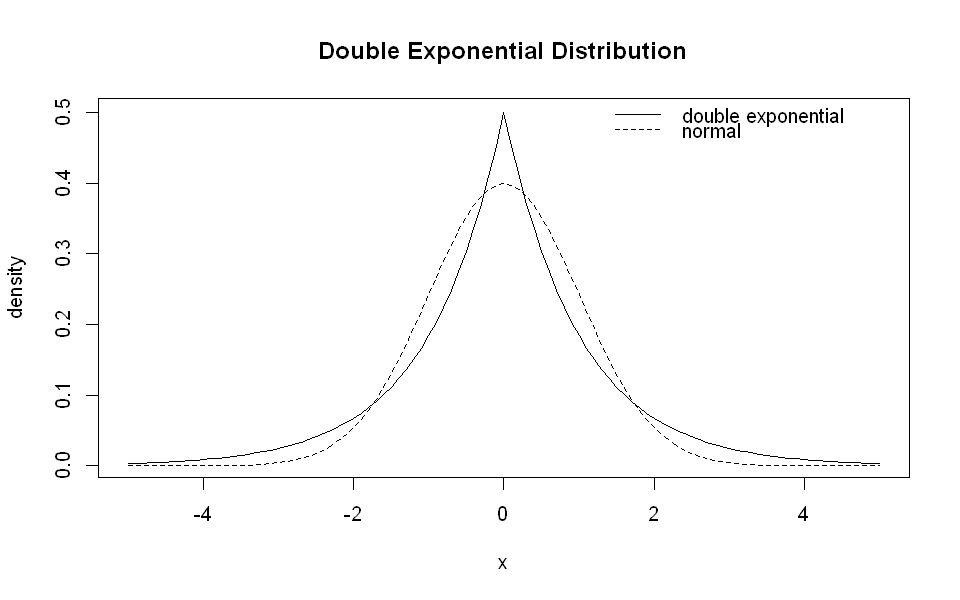

In [23]:
# The prior which I'm going to use is double exponential prior or Laplacian Prior. It favous values near zero.

ddexp = function(x, mu, tau){
    0.5*tau*exp(-tau*abs(x-mu))
}

rdexp = function(n, mu, tau){
    x = rnorm(n, 0.0, tau/sqrt(2))
    0.5*tau*exp(-tau*abs(x-mu))
}

options(repr.plot.width=8, repr.plot.height=5)

curve(ddexp(x, mu=0, tau=1.0), from=-5.0, to=5.0, ylab="density", main="Double Exponential Distribution")
curve(dnorm(x, mean=0, sd=1.0), from=-5.0, to=5.0, lty=2, add=TRUE)
legend("topright", legend = c("double exponential", "normal"), lty=c(1, 2), bty="n")

# Multi Way Additive Model

In [76]:
data_jags = list(
                    isSeasonA = as.integer(df$season == -1),
                    isSeasonB = as.integer(df$season == -0.33),
                    isSeasonC = as.integer(df$season == 0.33),
                    isSeasonD = as.integer(df$season == 1),
                    age = df$age,
                    isChildD = as.integer(df$childhood_disease)-1,
                    isTrauma = as.integer(df$trauma)-1,
                    isSurgery = as.integer(df$surgeries)-1,
                    isHighFeverA = as.integer(df$high_fever == -1),
                    isHighFeverB = as.integer(df$high_fever == 0),
                    isHighFeverC = as.integer(df$high_fever == 1),
                    isAlchoholicA = as.integer(df$alcoholic == 0.2),
                    isAlchoholicB = as.integer(df$alcoholic == 0.4),
                    isAlchoholicC = as.integer(df$alcoholic == 0.6),
                    isAlchoholicD = as.integer(df$alcoholic == 0.8),
                    isAlchoholicE = as.integer(df$alcoholic == 1),
                    isSmokerA = as.integer(df$smoking == -1),
                    isSmokerB = as.integer(df$smoking == 01),
                    isSmokerC = as.integer(df$smoking == 1),
                    sitting = df$sitting,
                    result = as.integer(df$diag_result == 0)
                )

In [77]:
params = c("int", "beta")

In [78]:
inits = function(){
    inits = list("int" = rnorm(1,0.0,100.0),
                 "beta" = rdexp(20, 0.0, 100.0))
}

In [79]:
mod1 = jags.model(file = "Models//Model1.jags", 
                  data = data_jags,
                  inits = inits,
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 21
   Total graph size: 2393

Initializing model



In [45]:
update(mod1, 1e3)

In [48]:
mod_1_sim = coda.samples(model = mod1, 
                         variable.names = params, 
                         n.iter = 1e4)

In [49]:
mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

# Multi Way Cell Mean Model

In [7]:
mod_3_str = " model {
    # Actual Bayesian Model Likelihood
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[woolGrp[i], tensGrp[i]], prec)
    }

    # Priors
    for (j in 1:max(woolGrp)){
        for (k in 1:max(tensGrp)){
            mu[j, k] ~ dnorm(0.0, 1.0/1.0e6)
    }}
    prec ~ dgamma(3/2.0, 3*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "